# Preprocessing

## Imports

In [33]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load Data

In [2]:
train_non_adverse = pd.read_csv("data/nam.csv")
train_adverse = pd.read_csv("data/am.csv")
train_random_additional = pd.read_csv("data/random.csv")
am_additional = pd.read_csv("data/am_additional.csv")
test = pd.read_csv("data/test.csv", usecols=["title", "article", "label"])

### Train Data

Filter only the labeled ones and drop if title or article is undefined

In [3]:
train_concat = pd.concat([train_non_adverse, train_adverse, train_random_additional, am_additional], ignore_index=True)
train_filtered = train_concat[(train_concat.label == "nam") | (train_concat.label == "am") | (train_concat.label == "random")]
train_filtered = train_filtered.dropna(subset=['title', 'article'])

In [4]:
train_filtered.describe()

,source,entity_name,entity_type,explanation,label,url,article,full_response,assessor,title
count,1195,1082,1086,665,1594,1296,1594,1196,728,1594
unique,9,793,17,381,3,1296,1594,1196,10,1582
top,Sebastien,John McAfee,individual,corruption,am,https://www.dailymail.co.uk/tvshowbiz/article-...,Over the last few weeks all eyes in the crypto...,[{'query': {'id': '1605369253561-31fd81422a05b...,Carel,John McAfee Indicted for Tax Evasion
freq,284,10,345,33,801,1,1,1,220,2


In [5]:
train_filtered.head(3)

,source,entity_name,entity_type,explanation,label,url,article,full_response,assessor,title
0,Darya,Kevin Morais,individual,award for bravery towards corruption,nam,https://www.nst.com.my/news/nation/2020/02/564...,PUTRAJAYA: The late senior deputy public prose...,[{'query': {'id': '1605373858510-22ed9e7516161...,Shakshi,Kevin Morais named as recipient of Internation...
1,Carel,NaN,NaN,Bribery law,nam,https://www.gov.uk/government/publications/bri...,Details\n\nThe Bribery Act 2010 creates a new ...,[{'query': {'id': '1605369929260-65690a650021b...,Dan,Bribery Act 2010 guidance
2,Carel,NaN,NaN,Abstract of Insider Trading article,nam,https://www.jstor.org/stable/3666053?seq=1,Abstract\n\nTrading by corporate insiders has ...,[{'query': {'id': '1605369732277-abfa02170cbde...,Dan,For independent researchers


In [6]:
train_filtered.label.value_counts()

am        801
nam       397
random    396
Name: label, dtype: int64

There are 3 label types:

* `am` - adverse media.
* `nam` -  non adverse media, contains topics related to adverse media (tax evasion, corruption, ...) but not accusing anyone (article about how to stop corruption). 
* `random` - article that doesn't fall in any category described above.

### Test Data

In [7]:
test.head()

,title,article,label
0,Caputo concealed Cayman Island offshore firms ...,"By Sandra Crucianelli, Emilia Delfino y From B...",1
1,California Man Pleads Guilty in $6 Million Art...,A California man pleaded guilty in federal cou...,1
2,Couple jailed for laundering £50m,A couple who ran a diamond trading business ha...,1
3,John Gilligan charged with money laundering of...,image copyrightRTÉ\n\nA Dublin man has been ch...,1
4,Grace Mugabe faces arrest in Mary Chiwenga Sty...,Zimbabwe News\n\nGrace Mugabe faces arrest in ...,1


In [8]:
test.label.value_counts()

1    97
0    62
Name: label, dtype: int64

* 0 is non-adverse/random
* 1 is adverse

## Functions

Here we add functions that provide different data sets accorfing to our needs

### Get full data (internal use)

Used by `getTrainData` function

In [9]:
def getData():
    train_data = pd.DataFrame([])
    train_data['text'] = train_filtered.article
    train_data['label'] = train_filtered.label.map(dict(am=1, nam=0, random=2))

    return train_data.copy()

### Get full data (internal use)

Used by `getTrainData` function

In [10]:
def get_n_sentences(n):
    train_data_sentences = pd.DataFrame([])
    train_data_sentences['text'] = train_filtered.article.apply(lambda a: " ".join(nltk.sent_tokenize(a)[0:n]))
    train_data_sentences['label'] = train_filtered.label.map(dict(am=1, nam=0, random=2))
    
    return train_data_sentences.copy()

### Full row by index (external use)

Useful if you want to get full row with all columns e.g. `url`.

This can be used when inpecting missclassified rows.

Also accepts array of indexes.

In [11]:
def getFullRowByIndex(idx):
    return train_filtered.loc[idx]

#### Examples of `getFullRowByIndex` function

##### Get full row of index 0 and 1

In [12]:
getFullRowByIndex([0, 1])

,source,entity_name,entity_type,explanation,label,url,article,full_response,assessor,title
0,Darya,Kevin Morais,individual,award for bravery towards corruption,nam,https://www.nst.com.my/news/nation/2020/02/564...,PUTRAJAYA: The late senior deputy public prose...,[{'query': {'id': '1605373858510-22ed9e7516161...,Shakshi,Kevin Morais named as recipient of Internation...
1,Carel,NaN,NaN,Bribery law,nam,https://www.gov.uk/government/publications/bri...,Details\n\nThe Bribery Act 2010 creates a new ...,[{'query': {'id': '1605369929260-65690a650021b...,Dan,Bribery Act 2010 guidance


### Get train data (external use)

Returns data set according to function arguments.
Joins title and article in 1 column.

Transforms `label` to integer.

Arguments:
* `include_random` - include random labels in data set
* `random_as_2` - return random labels as `2` (default is `0`)
* `shuffle` - shuffle the data set
* `no_title` - do not include the title
* `n_sentences` - return first n sentences (if `-1` returns all of them)

Returns:
* pandas data frame with 2 columns: `text`, `label`. Label `0` is non-adverse/random, `1` is adverse.

In [13]:
def getTrainData(include_random=False, random_as_2=False, shuffle=False, no_title=False, n_sentences=-1):
    td = None
    if n_sentences >= 0:
        td = get_n_sentences(n_sentences)
    else:
        td = getData()
    
    if not no_title:
        if n_sentences == 0:
            td['text'] = train_filtered.title
        else:
            td['text'] = pd.DataFrame({ 'title': train_filtered.title, 'article': td.text }).agg('.\n'.join, axis=1)
    
    if not include_random:
        td = td.loc[td['label'] != 2]
    
    if not random_as_2:
        td.loc[td['label'] == 2, 'label'] = 0
    
    if shuffle:
        td = td.sample(frac=1)
    
    return td.copy()

#### Examples of `getTrainData` function

##### Get full data

In [14]:
full = getTrainData(include_random=True)

In [15]:
full

,text,label
0,Kevin Morais named as recipient of Internation...,0
1,Bribery Act 2010 guidance.\nDetails\n\nThe Bri...,0
2,For independent researchers.\nAbstract\n\nTrad...,0
3,Global FinTech Company Implements Automated & ...,0
4,Pope Francis commits to clean finances amid sc...,0
...,...,...
1692,U.S indicts Venezuelan in kickback scheme link...,1
1693,Spokane health clinic owner charged with $5 mi...,1
1694,FirstEnergy credit rating downgraded to “junk”...,1
1695,Former Tangipahoa Parish Sheriff’s Office empl...,1


##### Get just title

In [19]:
title = getTrainData(include_random=True, n_sentences=0)

In [20]:
title

,text,label
0,Kevin Morais named as recipient of Internation...,0
1,Bribery Act 2010 guidance,0
2,For independent researchers,0
3,Global FinTech Company Implements Automated & ...,0
4,Pope Francis commits to clean finances amid sc...,0
...,...,...
1692,U.S indicts Venezuelan in kickback scheme link...,1
1693,Spokane health clinic owner charged with $5 mi...,1
1694,FirstEnergy credit rating downgraded to “junk”...,1
1695,Former Tangipahoa Parish Sheriff’s Office empl...,1


In [21]:
title.loc[0].text

'Kevin Morais named as recipient of International Anti-Corruption Award 2020'

##### Get just article body

In [22]:
body = getTrainData(include_random=True, no_title=True)

In [23]:
body

,text,label
0,PUTRAJAYA: The late senior deputy public prose...,0
1,Details\n\nThe Bribery Act 2010 creates a new ...,0
2,Abstract\n\nTrading by corporate insiders has ...,0
3,As FinTech organizations grow and expand their...,0
4,Pope Francis told European anti-money launderi...,0
...,...,...
1692,A dual Venezuelan-Italian citizen who controll...,1
1693,"The owner of a health clinic based in Spokane,...",1
1694,FirstEnergy‘s credit rating has been downgrade...,1
1695,A Tangipahoa Parish Sheriff’s Office employee ...,1


In [24]:
body.loc[0].text

'PUTRAJAYA: The late senior deputy public prosecutor Datuk Anthony Kevin Morais may have long passed but his commitment, determination and contributions towards fighting corruption is one legacy which lives on.\n\nMorais was named as one of the two recipients of the International Anti-Corruption Award 2020 at the Perdana International Anti-Corruption Champion Fund (PIACCF) launch, here tonight.\nMorais was abducted and murdered while on his way to work in September 2015, while investigating a corruption scandal.\n\nHis body was chopped up and put into a cement drum before it was discovered and confirmed through a DNA test.\n\nThe other award recipient was Novel Baswedan, the Head of Investigator for Indonesian’s Corruption Eradication Commission (KPK).\n\nNovel, from Jakarta, Indonesia, was attacked on April 11, 2017. He was returning from dawn prayers near his house in Kelapa Gading in North Jakarta when he was sprayed with chemical-laced water by his attackers.\n\nHe survived the att

##### Get title + first sentence

In [25]:
title_1st_sentence = getTrainData(include_random=True, n_sentences=1)

In [26]:
title_1st_sentence

,text,label
0,Kevin Morais named as recipient of Internation...,0
1,Bribery Act 2010 guidance.\nDetails\n\nThe Bri...,0
2,For independent researchers.\nAbstract\n\nTrad...,0
3,Global FinTech Company Implements Automated & ...,0
4,Pope Francis commits to clean finances amid sc...,0
...,...,...
1692,U.S indicts Venezuelan in kickback scheme link...,1
1693,Spokane health clinic owner charged with $5 mi...,1
1694,FirstEnergy credit rating downgraded to “junk”...,1
1695,Former Tangipahoa Parish Sheriff’s Office empl...,1


In [27]:
title_1st_sentence.loc[0].text

'Kevin Morais named as recipient of International Anti-Corruption Award 2020.\nPUTRAJAYA: The late senior deputy public prosecutor Datuk Anthony Kevin Morais may have long passed but his commitment, determination and contributions towards fighting corruption is one legacy which lives on.'

### Get test data (external use)

In [28]:
def getTestData(no_title=False, n_sentences=-1):
    td = pd.DataFrame([])
    if n_sentences >= 0:
        td['text'] = test.article.apply(lambda a: " ".join(nltk.sent_tokenize(a)[0:n_sentences]))
    else:
        td['text'] = test.article
    
    td['label'] = test.label
    
    td = td.copy()
    
    if not no_title:
        if n_sentences == 0:
            td['text'] = test.title
        else:
            td['text'] = pd.DataFrame({ 'title': test.title, 'article': td.text }).agg('.\n'.join, axis=1)
    
    return td.copy()

## Analysis

### Article body size

In [77]:
train_data_body = getTrainData(include_random=True, no_title=True)

In [78]:
cv = CountVectorizer()
test_cv = cv.fit_transform(train_data_body['text'].array)

In [79]:
train_data_body["word_count"] = np.sum(test_cv.toarray(), axis=1)
train_data_body = train_data_body.sort_values(by=['word_count'])
train_data_body

,text,label,word_count
1008,"MEXICO CITY, Oct 16 (Reuters) - Former Mexican...",1,42
1122,"August 21, 2020 by David Marchant\n\nThree UK ...",1,50
389,KYIV (Reuters) - The Ukrainian parliament must...,0,58
907,July 6 (Reuters) - U.S. prosecutors have charg...,1,61
194,Keiser University’s Bachelor of Arts degree in...,0,61
...,...,...,...
322,"Not to be confused with his predecessor, Ruhol...",0,5023
39,Uhuru Muigai Kenyatta (born 26 October 1961) i...,1,5081
464,"From Wikipedia, the free encyclopedia\n\nJump ...",0,5084
491,"From Wikipedia, the free encyclopedia\n\nJump ...",0,5217


In [80]:
train_data_body.word_count.describe()

count    1594.000000
mean      736.481179
std       670.340442
min        42.000000
25%       339.000000
50%       564.500000
75%       911.000000
max      6677.000000
Name: word_count, dtype: float64

In [88]:
train_data_body.word_count.mean()

736.4811794228357

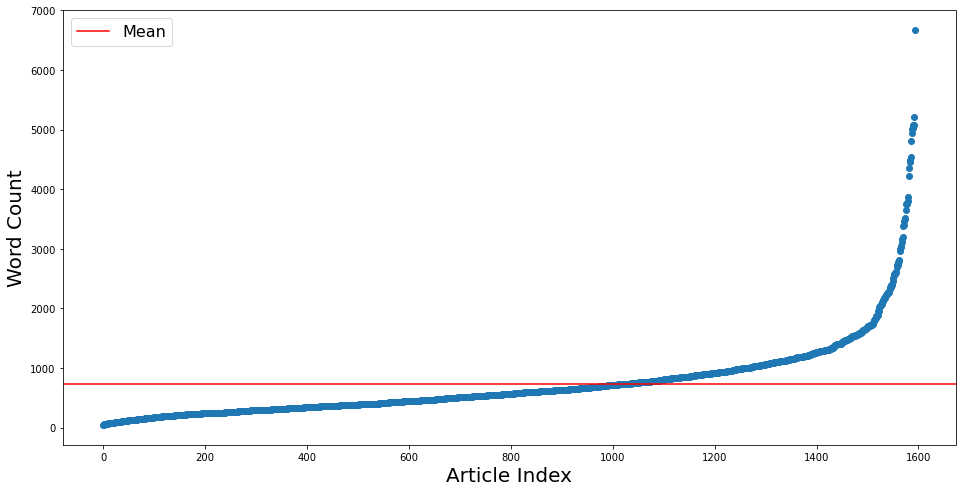

In [98]:
plt.rcParams["figure.figsize"] = (16,8)

plt.scatter(np.arange(0, len(train_data_body)), train_data_body.word_count)
plt.axline((0, train_data_body.word_count.mean()), slope=0, color="red", label="Mean")
plt.xlabel("Article Index", fontsize=20)
plt.ylabel("Word Count", fontsize=20)
plt.legend(fontsize=16)
plt.show()

### Article title size

In [71]:
train_data_title = getTrainData(include_random=True, n_sentences=0)

In [73]:
cv = CountVectorizer()
test_title_cv = cv.fit_transform(train_data_title['text'].array)

In [75]:
train_data_title["word_count"] = np.sum(test_title_cv.toarray(), axis=1)
train_data_title = train_data_title.sort_values(by=['word_count'])
train_data_title

,text,label,word_count
553,FCA admits revealing confidential details of 1...,0,1
1200,Treasury Sanctions Hizballah Leadership,1,1
1606,New Zealand mosque gunman pleads guilty to mur...,1,1
736,Riduan Isamuddin,1,1
1059,Brother of Colombian drug lord pleads guilty i...,1,1
...,...,...,...
1192,Fraudster Stephen Davey posed as police office...,1,33
1644,Vitol agrees to pay $160m in bribery and manip...,1,33
105,KPK Lauds Award Bestowed by Malaysia on Novel ...,0,37
322,Ali Khamenei,0,39


In [76]:
train_data_title.word_count.describe()

count    1594.000000
mean        9.863237
std         4.097692
min         1.000000
25%         8.000000
50%         9.000000
75%        12.000000
max        58.000000
Name: word_count, dtype: float64

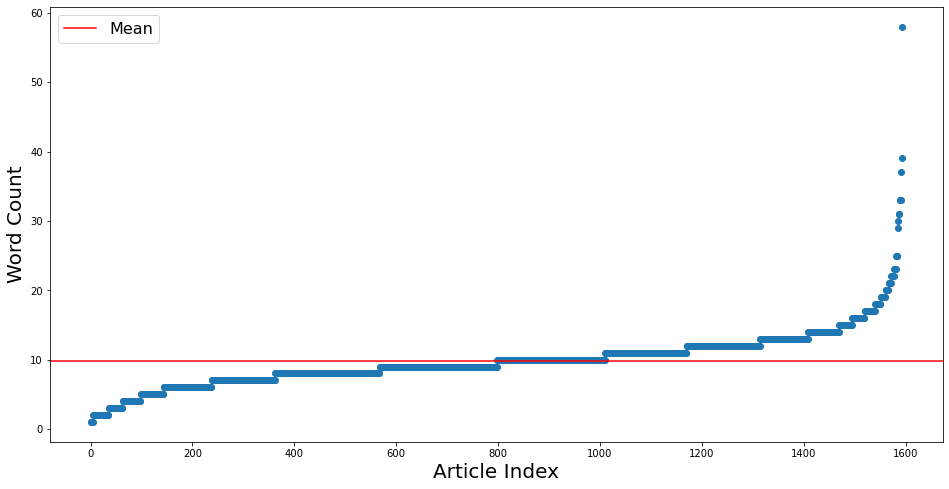

In [99]:
plt.rcParams["figure.figsize"] = (16,8)

plt.scatter(np.arange(0, len(train_data_title)), train_data_title.word_count)
plt.axline((0, train_data_title.word_count.mean()), slope=0, color="red", label="Mean")
plt.xlabel("Article Index", fontsize=20)
plt.ylabel("Word Count", fontsize=20)
plt.legend(fontsize=16)
plt.show()